In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import seaborn as sns
import glob
from tqdm.auto import tqdm

# User functions

In [3]:
def snr(x):
    return (
        x.query("value == 'raw_baseline'")["response"].mean()
        / x.query("value == 'background_smean_tmean'")["response"].iat[0]
    )

In [4]:
def get_outlier_rois(x, ref_field="response", nmads=6, scaling=1.4825796886582654):
    xhat = x.copy()
    series = xhat.set_index("roi")[ref_field]
    dev = (series - series.median()).abs()
    mad = dev.median()
    mad *= scaling
    outliers = dev[dev > mad * nmads].index
    exclude_rois = outliers
    return exclude_rois.tolist()

In [5]:
# setup_plotting_env()
fig_dir = "/storage/home/hcoda1/4/jmarkowitz30/shared_folder/active_lab_members/markowitz_jeffrey/panels/2025-05 (ScarCaMP paper)/"
os.makedirs(fig_dir, exist_ok=True)

# path to aggregate_data
merged_df = pd.read_parquet("/storage/home/hcoda1/4/jmarkowitz30/shared_folder/active_lab_members/markowitz_jeffrey/active_projects/red_calcium_screen/for_paper/invitro_results/aggregated_data_v2.parquet")

In [6]:
val_types = merged_df.value.unique()
val_types = [_ for _ in val_types if ("whole" in _) or ("saturated" in _)]

In [7]:
aliases = {
    "jm34": "s3",
    "jm35": "s3i",
}
merged_df["well_sanitized"] = merged_df["well_sanitized"].replace(aliases)
merged_df.loc[merged_df["well"].str.contains("JM47"), "well_sanitized"] = "s3i-l01-069"

In [8]:
wells = merged_df["well_sanitized"].sort_values().unique()

In [9]:
# these had technical issues
exclude_wells = [
    "s3-l01-021",
    "s3-l01-048",
    "s3i-l01-029",
    "s3-l01-012",
    "s3i-l01-042",
    "s3i-l01-043",
    "s3i-l01-044",
    "s3i-l01-045",
    "s3i-l01-046",
    "s3i-l01-047",
    "s3i-l01-048",
    "no_plasmid",
]
exclude_sessions = ["2023-11-19"]
wells = [_well for _well in wells if _well not in exclude_wells]
controls = ["mscarlet3"]
sz_threshold = 10
snr_threshold = 1.25

In [10]:
merged_df = merged_df.query("~session.str.contains('timecourse')").copy()
merged_df["session_date"] = pd.to_datetime(merged_df["session"])

In [11]:
l3b_idx = merged_df["session_date"] > pd.to_datetime("2024-09-10")

In [12]:
merged_df.loc[l3b_idx, "well_sanitized"] = merged_df.loc[l3b_idx, "well_sanitized"].str.replace("l03", "l03b")

In [13]:
merged_df = merged_df.groupby("well_sanitized").filter(lambda x: len(x) >= sz_threshold).copy()
merged_df = merged_df.query("well_sanitized not in @exclude_wells and session not in @exclude_sessions").copy()
snr_df = merged_df.groupby(["session", "well_sanitized"]).apply(snr).rename("snr")
merged_df = pd.merge(merged_df, snr_df, on=["session", "well_sanitized"])

/tmp/ipykernel_3478034/2730422264.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  snr_df = merged_df.groupby(["session", "well_sanitized"]).apply(snr).rename("snr")


In [14]:
merged_df["well_sanitized_session"] = merged_df[["well_sanitized", "session"]].agg("_".join, axis=1)

In [15]:
merged_df["is_jrcamp"] = False
merged_df.loc[merged_df["well_sanitized"].isin(["jrcamp1b", "jm27"]), "is_jrcamp"] = True

In [16]:
merged_df = merged_df.query("snr > @snr_threshold").copy()

In [17]:
merged_df["control_well"] = False
merged_df.loc[merged_df["well_sanitized"].isin(["mscarlet3"]), "control_well"] = True
merged_df["control_well"].fillna(False, inplace=True)

/tmp/ipykernel_3478034/217970978.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df["control_well"].fillna(False, inplace=True)


In [18]:
merged_df.loc[merged_df["well_sanitized"] == "s3i-l01-069", "is_scarcamp"] = True
merged_df["is_scarcamp"].fillna(False, inplace=True)

/tmp/ipykernel_3478034/1296852641.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df["is_scarcamp"].fillna(False, inplace=True)
/tmp/ipykernel_3478034/1296852641.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df["is_scarcamp"].fillna(False, inplace=True)


In [19]:
exclude_rois = (
    merged_df.query("value == 'raw_percent_iono_over_baseline'")
    .groupby(["session", "well_sanitized"])
    .apply(get_outlier_rois, include_groups=False)
)

In [20]:
merged_df = merged_df.groupby(["session", "well_sanitized"], group_keys=False).apply(
    lambda x: x.loc[~x["roi"].isin(exclude_rois.loc[x.name])]
)

/tmp/ipykernel_3478034/440152919.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged_df = merged_df.groupby(["session", "well_sanitized"], group_keys=False).apply(


In [21]:
merged_df.head()

,roi,response,value,frame,phase,filename,session,well,well_sanitized,session_date,snr,well_sanitized_session,is_jrcamp,control_well,is_scarcamp
44496,0,24.515131,raw_percent_iono_over_baseline,NaN,None,/storage/home/hcoda1/4/jmarkowitz30/shared_fol...,2023-10-26,Plate1_E.2_JM28_jRCaMP1b_0.4ug_20X,jrcamp1b,2023-10-26,4.582537,jrcamp1b_2023-10-26,True,False,False
44497,1,54.191349,raw_percent_iono_over_baseline,NaN,None,/storage/home/hcoda1/4/jmarkowitz30/shared_fol...,2023-10-26,Plate1_E.2_JM28_jRCaMP1b_0.4ug_20X,jrcamp1b,2023-10-26,4.582537,jrcamp1b_2023-10-26,True,False,False
44498,2,2.515382,raw_percent_iono_over_baseline,NaN,None,/storage/home/hcoda1/4/jmarkowitz30/shared_fol...,2023-10-26,Plate1_E.2_JM28_jRCaMP1b_0.4ug_20X,jrcamp1b,2023-10-26,4.582537,jrcamp1b_2023-10-26,True,False,False
44499,3,47.624470,raw_percent_iono_over_baseline,NaN,None,/storage/home/hcoda1/4/jmarkowitz30/shared_fol...,2023-10-26,Plate1_E.2_JM28_jRCaMP1b_0.4ug_20X,jrcamp1b,2023-10-26,4.582537,jrcamp1b_2023-10-26,True,False,False
44500,4,42.699772,raw_percent_iono_over_baseline,NaN,None,/storage/home/hcoda1/4/jmarkowitz30/shared_fol...,2023-10-26,Plate1_E.2_JM28_jRCaMP1b_0.4ug_20X,jrcamp1b,2023-10-26,4.582537,jrcamp1b_2023-10-26,True,False,False


# Sort by different qualities, then print out rankings...

In [22]:
signal_col = "ratio_percent_iono_over_baseline"
baseline_col = "raw_baseline"
filter_col = signal_col

In [23]:
plt_df2 = merged_df.query("~well_sanitized_session.str.contains('l02')").copy()

In [24]:
# merged_df["value"].unique()

In [25]:
col_rename = {0: "parent", 1: "library_number", 2: "variant_number"}

# parent, library number, variant
well_properties = (
    plt_df2["well_sanitized"]
    .str.extract("([a-z|0-9]+)-([a-z|0-9]+)-([a-z|0-9]+)")
    .apply(pd.Series)
    .rename(columns=col_rename)
)

try:
    plt_df2 = plt_df2.join(well_properties)
except ValueError:
    plt_df2 = plt_df2.drop(well_properties.columns, axis=1).join(well_properties)

plt_df2 = plt_df2.dropna(subset=well_properties.columns)
plt_df2["well_sanitized2"] = plt_df2[well_properties.columns].agg("-".join, axis=1)

In [26]:
best_sessions = (
    plt_df2.query("value == @filter_col")
    .groupby(["well_sanitized", "well_sanitized_session"])["response"]
    .apply(lambda x: x.abs().mean())
    .groupby("well_sanitized")
    .idxmax()
)
best_sessions = [_[1] for _ in best_sessions.tolist()]
plt_df2 = plt_df2.query("well_sanitized_session.isin(@best_sessions)")

In [28]:
dff0_sorted_wells = list(
    plt_df2.query("value == @signal_col")
    .groupby(["well_sanitized2", "value"])["response"]
    .median()
    .sort_values()
    .index
)

dff0_sorted_wells = [_[0] for _ in dff0_sorted_wells]
dff0_sorted_wells = [_ for _ in dff0_sorted_wells if (_ not in controls) and (_ not in exclude_wells)]
dff0_sorting_color = {_well: _idx for _idx, _well in enumerate(dff0_sorted_wells)}
plt_df2["dff0_sorted_well_color"] = plt_df2["well_sanitized2"].map(dff0_sorting_color)
include_wells = list(plt_df2["well_sanitized2"].unique())
well_order = [_ for _ in dff0_sorted_wells if "jrcamp" not in _.lower() and _ in include_wells]

In [29]:
boxplot_props = {
    "boxprops": {"edgecolor": "none"},
    "medianprops": {"color": "m"},
    "whiskerprops": {"color": [0.45, 0.45, 0.45]},
    # "capprops": {"color": "magenta"},
}

In [30]:
from calcium_imaging_analysis.fig import setup_plotting_env

In [31]:
setup_plotting_env()

In [32]:
variances = plt_df2.query("value==@signal_col").groupby("well_sanitized2")["response"].std()
high_variance = variances[variances > 10].index.tolist()

In [33]:
scale_bars_y = {
    signal_col: 5,
    baseline_col: 200,
}
scale_bar_x = 30

In [34]:
colors = sns.color_palette("tab20")

In [36]:
true_color = colors[6]
false_color = colors[0]

dist_to_white = np.array([1, 1, 1]) - np.array(false_color)
new_rgb = np.array(false_color) + 0.2 * dist_to_white

palette = {
    True: true_color,
    False: new_rgb,
}

In [37]:
use_scalebars = True

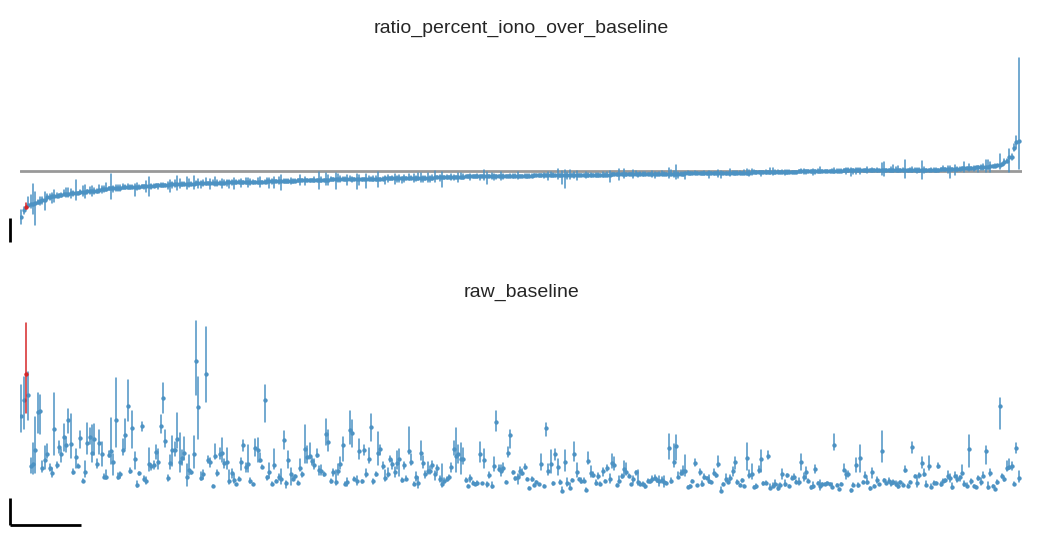

In [38]:
g = sns.catplot(
    data=plt_df2,
    x="well_sanitized2",
    y="response",
    kind="point",
    row="value",
    estimator="median",
    errorbar=("ci", 95),
    row_order=[signal_col, baseline_col],
    sharey=False,
    sharex=True,
    order=well_order,
    palette=palette,
    aspect=3.85,
    height=1.5,
    linewidth=0.55,
    markersize=1.15,
    hue="is_scarcamp",
    dodge=False,
    linestyle="none",
    legend=False,
)
g.set(
    xlabel="",
    ylabel="Percent dF/F0",
    xticks=[0, len(well_order)],
    xticklabels=[0, len(well_order)],
    xlim=(-0.5, len(well_order) + 0.5),
)
g.set_titles(row_template="{row_name}", col_template="{col_name}")
g.axes[0][0].axhline(y=0, color="k", alpha=0.4, zorder=-300)
g.axes[1][0].set_ylabel("Pixel value")
g.axes[1][0].set_ylim(0, 1500)
g.axes[1][0].set_yticks((0, 1500))
sns.despine(offset=5, trim=True)

if use_scalebars:
    for _ax, _col in zip(g.axes.ravel(), [signal_col, baseline_col]):
        _ax.axis("off")
        ylims = _ax.get_ylim()
        xlims = _ax.get_xlim()
        xrange = xlims[1] - xlims[0]
        yrange = ylims[1] - ylims[0]
        xpos = xlims[0] - xrange / 100
        ypos = ylims[0] - yrange / 20
        _ax.plot([xpos, xpos], [ypos, ypos + scale_bars_y[_col]], "k-", clip_on=False, solid_capstyle="butt")
    _ax.plot([xpos, xpos + scale_bar_x], [ypos, ypos], "k-", clip_on=False, solid_capstyle="butt")

# if we just want to show a scale bar, chop out the axes and add them!

# g.fig.tight_layout()
if use_scalebars:
    g.fig.savefig(
        os.path.join(fig_dir, f"library_plots-y-{scale_bars_y}-x-{scale_bar_x}.pdf"), dpi=600, bbox_inches="tight"
    )
else:
    g.fig.savefig(os.path.join(fig_dir, f"library_plots.pdf"), dpi=600, bbox_inches="tight")